<a href="https://colab.research.google.com/github/cinnaavox/favorita_sales_forecasting/blob/main/data_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🧩 Block 1 — Setup & Support-Dateien laden

In [2]:
!pip -q install pyarrow fastparquet gdown

import os, io, gc, shutil, requests
import numpy as np
import pandas as pd
import gdown

if 'make_drive_url' not in globals():
    def make_drive_url(file_id): return f"https://drive.google.com/uc?id={file_id}"

if 'load_csv_from_url' not in globals():
    def load_csv_from_url(url):
        r = requests.get(url); r.raise_for_status()
        return pd.read_csv(io.StringIO(r.text))

file_ids = {
    "holiday_events": "1RMjSuqHXHTwAw_PGD5XVjhA3agaAGHDH",
    "items": "1ogMRixVhNY6XOJtIRtkRllyOyzw1nqya",
    "oil": "1Q59vk2v4WQ-Rpc9t2nqHcsZM3QWGFje_",
    "stores": "1Ei0MUXmNhmOcmrlPad8oklnFEDM95cDi",
    "train": "1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv",
    "transactions": "1PW5LnAEAiL43fI5CRDn_h6pgDG5rtBW_"
}

df_items        = load_csv_from_url(make_drive_url(file_ids["items"]))
df_stores       = load_csv_from_url(make_drive_url(file_ids["stores"]))
df_oil          = load_csv_from_url(make_drive_url(file_ids["oil"]))
df_transactions = load_csv_from_url(make_drive_url(file_ids["transactions"]))
df_holiday      = load_csv_from_url(make_drive_url(file_ids["holiday_events"]))

# Datumsfelder
for _df, col in [(df_oil,'date'), (df_transactions,'date'), (df_holiday,'date')]:
    _df[col] = pd.to_datetime(_df[col], errors='coerce')

# Ölpreis-Lücken schließen
df_oil['dcoilwtico'] = pd.to_numeric(df_oil['dcoilwtico'], errors='coerce').interpolate('linear').ffill().bfill()

print({
    'items': df_items.shape, 'stores': df_stores.shape, 'oil': df_oil.shape,
    'transactions': df_transactions.shape, 'holiday': df_holiday.shape
})

{'items': (4100, 4), 'stores': (54, 5), 'oil': (1218, 2), 'transactions': (83488, 3), 'holiday': (350, 6)}


## 📍 Block 2 — Guayas-Stores bestimmen

In [3]:
guayas_store_ids = df_stores.loc[df_stores['state']=='Guayas','store_nbr'].unique()
print("Anzahl Guayas-Stores:", len(guayas_store_ids))

Anzahl Guayas-Stores: 11


## 📥 Block 3 — train.csv chunked lesen → Guayas filtern → Parts schreiben

In [4]:
TRAIN_PATH = "train.csv"
if not os.path.exists(TRAIN_PATH):
    gdown.download(make_drive_url(file_ids["train"]), TRAIN_PATH, quiet=False)

PARTS_DIR = "/content/guayas_parts"
if os.path.exists(PARTS_DIR):
    shutil.rmtree(PARTS_DIR)
os.makedirs(PARTS_DIR, exist_ok=True)

usecols = ['date','store_nbr','item_nbr','unit_sales','onpromotion']
dtypes  = {'store_nbr':'int16','item_nbr':'int32','unit_sales':'float32','onpromotion':'object'}

chunksize = 10**6
part_idx  = 0
for chunk in pd.read_csv(TRAIN_PATH, usecols=usecols, dtype=dtypes,
                         parse_dates=['date'], chunksize=chunksize):
    filt = chunk[chunk['store_nbr'].isin(guayas_store_ids)]
    if len(filt):
        filt.to_parquet(os.path.join(PARTS_DIR, f"part_{part_idx:03d}.parquet"), index=False)
        part_idx += 1
    del chunk, filt
    gc.collect()

print("geschriebene Parts:", len([f for f in os.listdir(PARTS_DIR) if f.endswith('.parquet')]))

Downloading...
From (original): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv
From (redirected): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv&confirm=t&uuid=176289fb-2bb3-4429-b2e6-c83996b792f4
To: /content/train.csv
100%|██████████| 5.00G/5.00G [00:49<00:00, 100MB/s]


geschriebene Parts: 126


##💡 Hint (Top-3 Familien wählen)

In [7]:
# Größte Familien finden:
df_items['family'].value_counts().head(3)

# Dann alle item_nbr behalten, die zu diesen Familien gehören:
keep_items = df_items[df_items['family'].isin(
    df_items['family'].value_counts().head(3).index
)]['item_nbr'].unique()

In [8]:
## ✅ Solution (Top-3 Familien + Filter)
items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['family', 'item_count']
top_3_families = items_per_family.head(3)['family'].tolist()

keep_items = df_items[df_items['family'].isin(top_3_families)]['item_nbr'].unique()
print("Top-3 Familien:", top_3_families, " | Items:", len(keep_items))

Top-3 Familien: ['GROCERY I', 'BEVERAGES', 'CLEANING']  | Items: 2393


In [9]:
# Top-3 Familien ermitteln und Items dieser Familien behalten
top3_families = df_items['family'].value_counts().head(3).index.tolist()
keep_items = df_items[df_items['family'].isin(top3_families)]['item_nbr'].unique()

print("Top-3 Familien:", top3_families)
print("Anzahl Items in Top-3:", len(keep_items))

Top-3 Familien: ['GROCERY I', 'BEVERAGES', 'CLEANING']
Anzahl Items in Top-3: 2393


In [10]:
# Häufigkeiten je Familie
items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['family', 'item_count']

# Top-3 Familienliste
top_3_families = items_per_family.head(3)['family'].tolist()
print("Top-3 Familien:", top_3_families)

# Alle Item-IDs dieser Familien
keep_items = df_items[df_items['family'].isin(top_3_families)]['item_nbr'].unique()
print("Anzahl Items in Top-3:", len(keep_items))

Top-3 Familien: ['GROCERY I', 'BEVERAGES', 'CLEANING']
Anzahl Items in Top-3: 2393


## 🧪 Block 4 — 300k-Sample bauen (nur Top-3 Familien), Grund-Cleaning

In [11]:
TARGET = 300_000
pool, rows = [], 0
part_files = sorted([os.path.join(PARTS_DIR, f) for f in os.listdir(PARTS_DIR) if f.endswith(".parquet")])

for fp in part_files:
    part = pd.read_parquet(fp, columns=['date','store_nbr','item_nbr','unit_sales','onpromotion'])
    part = part[part['item_nbr'].isin(keep_items)]
    if len(part):
        pool.append(part); rows += len(part)
    del part; gc.collect()
    if rows >= TARGET * 1.5:
        break

if not pool:
    raise RuntimeError("Kein passender Slice gefunden – prüfe Guayas-Filter/Top-3.")

df_train = pd.concat(pool, ignore_index=True)
if len(df_train) >= TARGET:
    df_train = df_train.sample(n=TARGET, random_state=42).reset_index(drop=True)
else:
    print(f"Warnung: nur {len(df_train):,} Zeilen < TARGET={TARGET:,}")

# Cleaning/Types
df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)
df_train['unit_sales']  = df_train['unit_sales'].clip(lower=0)
df_train['date']        = pd.to_datetime(df_train['date'], errors='coerce')

# Familien/Perishable anhängen
df_train = df_train.merge(df_items[['item_nbr','family','perishable']], on='item_nbr', how='left')
df_train['perishable'] = df_train['perishable'].astype(bool)

print("df_train (Guayas, Top-3, 300k):", df_train.shape)
del pool; gc.collect()

df_train (Guayas, Top-3, 300k): (300000, 7)


/tmp/ipython-input-86671830.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)


0

## 📅 Block 5 — Kalender füllen pro (Store, Item)

In [12]:
RUN_CALENDAR_FILL = True

if RUN_CALENDAR_FILL:
    def fill_calendar(group):
        g = (group.set_index('date').sort_index().asfreq('D', fill_value=0))
        g['store_nbr'] = group['store_nbr'].iloc[0]
        g['item_nbr']  = group['item_nbr'].iloc[0]
        g['family']    = group['family'].iloc[0]
        g['perishable']= group['perishable'].iloc[0]
        # onpromotion für neue Tage = False
        if 'onpromotion' in g.columns:
            g['onpromotion'] = g['onpromotion'].astype(bool)
        return g.reset_index()

    df_train = (df_train.groupby(['store_nbr','item_nbr'], group_keys=False)
                        .apply(fill_calendar))
    print("nach Kalender-Fill:", df_train.shape)

nach Kalender-Fill: (665669, 7)


/tmp/ipython-input-3488846848.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fill_calendar))


## 🧱 Block 6 — Feature Engineering (Date-Parts + 7-Tage Rolling)

In [13]:
df_train['year']        = df_train['date'].dt.year.astype('int16')
df_train['month']       = df_train['date'].dt.month.astype('int8')
df_train['day']         = df_train['date'].dt.day.astype('int8')
df_train['day_of_week'] = df_train['date'].dt.dayofweek.astype('int8')

df_train = df_train.sort_values(['store_nbr','item_nbr','date']).reset_index(drop=True)
df_train['unit_sales_7d_avg'] = (
    df_train.groupby(['store_nbr','item_nbr'])['unit_sales']
            .transform(lambda s: s.rolling(window=7, min_periods=1).mean())
            .astype('float32')
)

print("Features ok. Beispielspalten:", df_train.columns[:12].tolist(), "…")

Features ok. Beispielspalten: ['date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion', 'family', 'perishable', 'year', 'month', 'day', 'day_of_week', 'unit_sales_7d_avg'] …


## 👀 Block 7 — Mini-EDA (Trend, Heatmap, Perishable-Anteil)

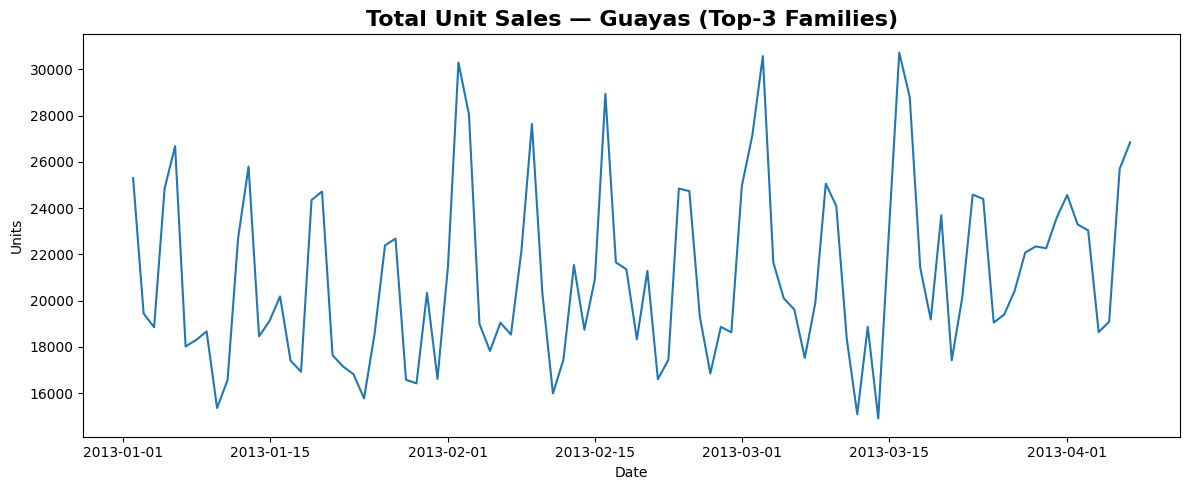

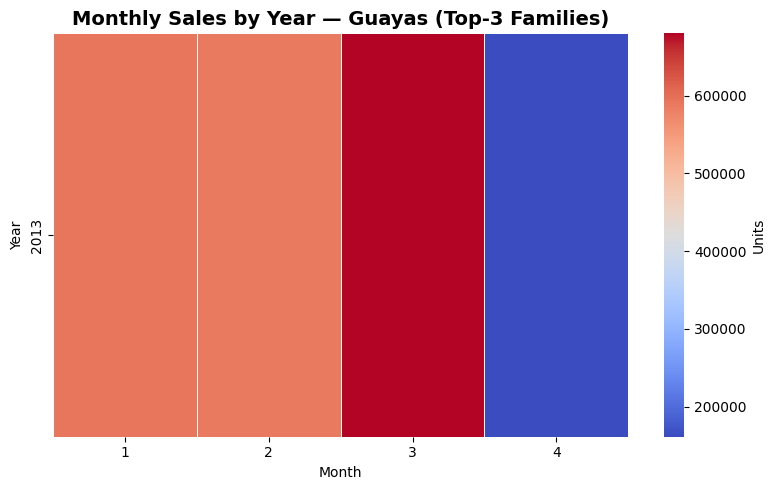

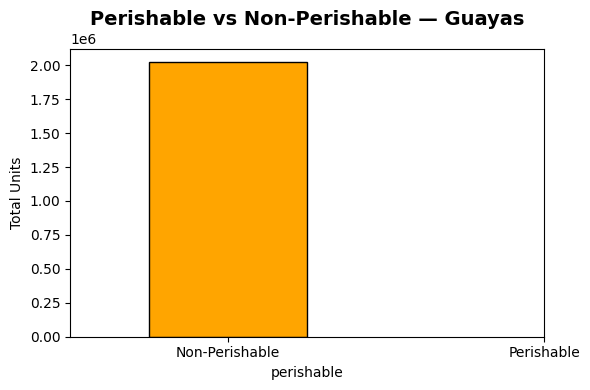

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# tägliche Totals
daily = df_train.groupby('date', observed=True)['unit_sales'].sum().sort_index()

plt.figure(figsize=(12,5))
plt.plot(daily.index, daily.values)
plt.title("Total Unit Sales — Guayas (Top-3 Families)", fontsize=16, fontweight='bold')
plt.xlabel("Date"); plt.ylabel("Units"); plt.tight_layout(); plt.show()

# Year-Month Heatmap
ym = (df_train.groupby(['year','month'], observed=True)['unit_sales']
      .sum().unstack().fillna(0))

plt.figure(figsize=(8,5))
sns.heatmap(ym, cmap='coolwarm', linewidths=0.5, linecolor='white', cbar_kws={'label':'Units'})
plt.title("Monthly Sales by Year — Guayas (Top-3 Families)", fontsize=14, fontweight='bold')
plt.xlabel("Month"); plt.ylabel("Year"); plt.tight_layout(); plt.show()

# Perishable-Anteil
share = df_train.groupby('perishable', observed=True)['unit_sales'].sum()
plt.figure(figsize=(6,4))
share.plot(kind='bar', edgecolor='black', color=['orange','green'])
plt.title("Perishable vs Non-Perishable — Guayas", fontsize=14, fontweight='bold')
plt.xticks([0,1], ['Non-Perishable','Perishable'], rotation=0)
plt.ylabel("Total Units"); plt.tight_layout(); plt.show()

## 💾 Block 8 — Persistenz (für Week-2 wieder laden)

In [15]:
from google.colab import drive
drive.mount('/content/drive')

SAVE_DIR = "/content/drive/MyDrive/time_series_course_guayas"
os.makedirs(SAVE_DIR, exist_ok=True)

pkl_path = os.path.join(SAVE_DIR, "guayas_prepared.pkl")
csv_path = os.path.join(SAVE_DIR, "guayas_prepared.csv")
par_path = os.path.join(SAVE_DIR, "guayas_prepared.parquet")

df_train.to_pickle(pkl_path)
df_train.to_csv(csv_path, index=False)
df_train.to_parquet(par_path, index=False)

print("Gespeichert:\n", pkl_path, "\n", csv_path, "\n", par_path)

Mounted at /content/drive
Gespeichert:
 /content/drive/MyDrive/time_series_course_guayas/guayas_prepared.pkl 
 /content/drive/MyDrive/time_series_course_guayas/guayas_prepared.csv 
 /content/drive/MyDrive/time_series_course_guayas/guayas_prepared.parquet


## 🔁 Block 9 — Reload-Probe (sanity check)

In [16]:
df_reload = pd.read_pickle(pkl_path)
print("Reload ok:", df_reload.shape, "| Zeitraum:",
      df_reload['date'].min().date(), "→", df_reload['date'].max().date())
print("Stores:", df_reload['store_nbr'].nunique(),
      "| Items:", df_reload['item_nbr'].nunique(),
      "| Families:", df_reload['family'].nunique())

Reload ok: (665669, 12) | Zeitraum: 2013-01-02 → 2013-04-07
Stores: 9 | Items: 1099 | Families: 3
